# 1. 本节目标
本节中，我们要提取出猫眼电影TOP100的电影名称、时间、评分、图片等信息，提取的站点URL为http://maoyan.com/board/4 提取的结果会以文件形式保存下来。

# 2. 准备工作
在本节开始之前，请确保已经正确安装好了requests库。如果没有安装，可以参考第1章的安装说明。

# 3. 抓取分析
我们需要抓取的目标站点为http://maoyan.com/board/4 ，打开之后便可以查看到榜单信息

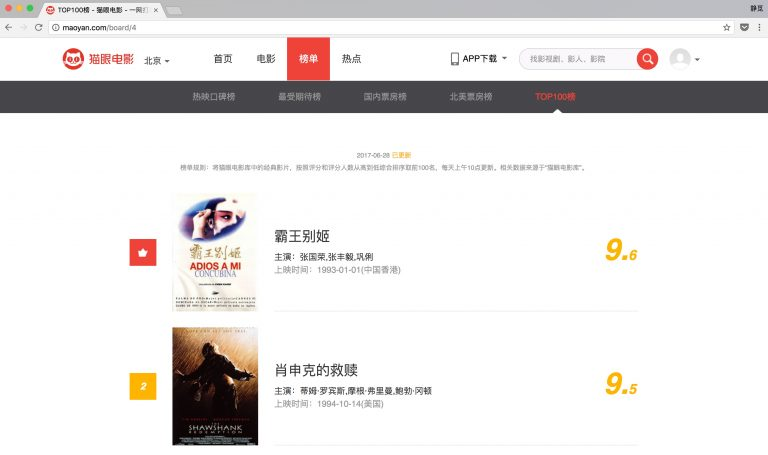

可以发现页面的URL变成http://maoyan.com/board/4?offset=10 ， 比之前的URL多了一个参数，那就是offset=10，而目前显示的结果是排行11~20名的电影，初步推断这是一个偏移量的参数。再点击下一页，发现页面的URL变成了http://maoyan.com/board/4?offset=20 ，参数offset变成了20，而显示的结果是排行21~30的电影。

由此可以总结出规律，offset代表偏移量值，如果偏移量为n，则显示的电影序号就是n+1到n+10，每页显示10个。所以，如果想获取TOP100电影，只需要分开请求10次，而10次的offset参数分别设置为0、10、20、…90即可，这样获取不同的页面之后，再用正则表达式提取出相关信息，就可以得到TOP100的所有电影信息了。

# 4. 抓取首页
接下来用代码实现这个过程。首先抓取第一页的内容。我们实现了get_one_page()方法，并给它传入url参数。然后将抓取的页面结果返回，再通过main()方法调用。初步代码实现如下：

```
import requests
 
def get_one_page(url):
    response = requests.get(url)
    if response.status_code == 200:
        return response.text
    return None
 
def main():
    url = 'http://maoyan.com/board/4'
    html = get_one_page(url)
    print(html)
 
main()
```

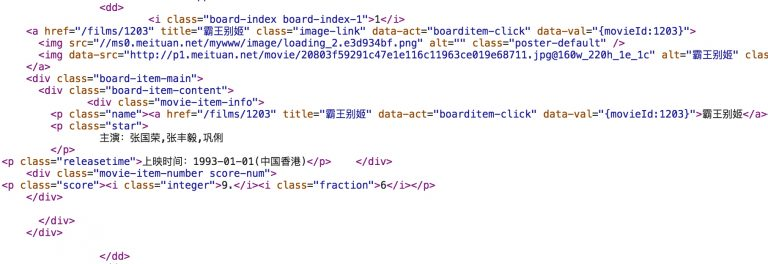

可以看到，一部电影信息对应的源代码是一个dd节点，我们用正则表达式来提取这里面的一些电影信息。首先，需要提取它的排名信息。而它的排名信息是在class为board-index的i节点内，这里利用非贪婪匹配来提取i节点内的信息，正则表达式写为：

`<dd>.*?board-index.*?>(.*?)</i>`

随后需要提取电影的图片。可以看到，后面有a节点，其内部有两个img节点。经过检查后发现，第二个img节点的data-src属性是图片的链接。这里提取第二个img节点的data-src属性，正则表达式可以改写如下：

`<dd>.*?board-index.*?>(.*?)</i>.*?data-src="(.*?)`

再往后，需要提取电影的名称，它在后面的p节点内，class为name。所以，可以用name做一个标志位，然后进一步提取到其内a节点的正文内容，此时正则表达式改写如下：

`<dd>.*?board-index.*?>(.*?)</i>.*?data-src="(.*?)".*?name.*?a.*?>(.*?)</a>`

再提取主演、发布时间、评分等内容时，都是同样的原理。最后，正则表达式写为：

```<dd>.*?board-index.*?>(.*?)</i>.*?data-src="(.*?)".*?name.*?a.*?>(.*?)</a>.*?star.*?>(.*?)</p>.*?releasetime.*?>(.*?)</p>.*?integer.*?>(.*?)</i>.*?fraction.*?>(.*?)</i>.*?</dd>```

这样一个正则表达式可以匹配一个电影的结果，里面匹配了7个信息。接下来，通过调用findall()方法提取出所有的内容。

接下来，我们再定义解析页面的方法parse_one_page()，主要是通过正则表达式来从结果中提取出我们想要的内容

```
def parse_one_page(html):
    pattern = re.compile(
        '<dd>.*?board-index.*?>(.*?)</i>.*?data-src="(.*?)".*?name.*?a.*?>(.*?)</a>.*?star.*?>(.*?)</p>.*?releasetime.*?>(.*?)</p>.*?integer.*?>(.*?)</i>.*?fraction.*?>(.*?)</i>.*?</dd>',
        re.S)
    items = re.findall(pattern, html)
    print(items)
```

但这样还不够，数据比较杂乱，我们再将匹配结果处理一下，遍历提取结果并生成字典

```
def parse_one_page(html):
    pattern = re.compile(
        '<dd>.*?board-index.*?>(.*?)</i>.*?data-src="(.*?)".*?name.*?a.*?>(.*?)</a>.*?star.*?>(.*?)</p>.*?releasetime.*?>(.*?)</p>.*?integer.*?>(.*?)</i>.*?fraction.*?>(.*?)</i>.*?</dd>',
        re.S)
    items = re.findall(pattern, html)
    for item in items:
        yield {
            'index': item[0],
            'image': item[1],
            'title': item[2].strip(),
            'actor': item[3].strip()[3:] if len(item[3]) > 3 else '',
            'time': item[4].strip()[5:] if len(item[4]) > 5 else '',
            'score': item[5].strip() + item[6].strip()
        }
        ```

# 6. 写入文件
随后，我们将提取的结果写入文件，这里直接写入到一个文本文件中。这里通过JSON库的dumps()方法实现字典的序列化，并指定ensure_ascii参数为False，这样可以保证输出结果是中文形式而不是Unicode编码。代码如下：

```def write_to_json(content):
    with open('result.txt','a') as f:
        print(type(json.dumps(content)))
        f.write(json.dumps(content,ensure_ascii=False).encode('utf-8'))```

# 7. 整合代码
最后，实现main()方法来调用前面实现的方法，将单页的电影结果写入到文件。相关代码如下：

```

def main():
    url = 'http://maoyan.com/board/4'
    html = get_one_page(url)
    for item in parse_one_page(html):
        write_to_json(item)```

# 8. 分页爬取
因为我们需要抓取的是TOP100的电影，所以还需要遍历一下，给这个链接传入offset参数，实现其他90部电影的爬取，此时添加如下调用即可：

```if __name__ == '__main__':
    for i in range(10):
        main(offset=i * 10)```

这里还需要将main()方法修改一下，接收一个offset值作为偏移量，然后构造URL进行爬取。实现代码如下：

```def main(offset):
    url = 'http://maoyan.com/board/4?offset=' + str(offset)
    html = get_one_page(url)
    for item in parse_one_page(html):
        print(item)
        write_to_file(item)```

In [3]:
import json
import requests
from requests.exceptions import RequestException
import re
import time
 
def get_one_page(url):
    try:
        response = requests.get(url)
        if response.status_code == 200:
            return response.text
        return None
    except RequestException:
        return None
 
def parse_one_page(html):
    pattern = re.compile('<dd>.*?board-index.*?>(\d+)</i>.*?data-src="(.*?)".*?name"><a'
                         + '.*?>(.*?)</a>.*?star">(.*?)</p>.*?releasetime">(.*?)</p>'
                         + '.*?integer">(.*?)</i>.*?fraction">(.*?)</i>.*?</dd>', re.S)
    items = re.findall(pattern, html)
    for item in items:
        yield {
            'index': item[0],
            'image': item[1],
            'title': item[2],
            'actor': item[3].strip()[3:],
            'time': item[4].strip()[5:],
            'score': item[5] + item[6]
        }
 
def write_to_file(content):
    with open('result.txt', 'a', encoding='utf-8') as f:
        f.write(json.dumps(content, ensure_ascii=False) + '\n')
 
def main(offset):
    url = 'http://maoyan.com/board/4?offset=' + str(offset)
    html = get_one_page(url)
    for item in parse_one_page(html):
        print(item)
        write_to_file(item)
 
if __name__ == '__main__':
    for i in range(10):
        main(offset=i * 10)
        time.sleep(1)